#                                  CGM Time Series Analysis



In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
import matplotlib.dates as mdates


## Importing the data into the notebook

In [27]:
# reading in my CGM data and storing as a csv
url = "AbdulnourDualeh_glucose_19-3-2024.csv"

In [28]:
# storing the csv data in a pandas dataframe
df = pd.read_csv(url, header=1)

In [29]:
 # printing the first 5 rows of data to inspect it
df.head(5)

,Device,Serial Number,Device Timestamp,Record Type,Historic Glucose mmol/L,Scan Glucose mmol/L,Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Carbohydrates (servings),Non-numeric Long-Acting Insulin,Long-Acting Insulin Value (units),Notes,Strip Glucose mmol/L,Ketone mmol/L,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units)
0,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 10:41,0,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 10:56,0,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 11:11,0,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 11:26,0,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FreeStyle LibreLink,FFA64743-D4D5-4C0A-A28B-FB65C7F0EB80,07-06-2022 11:41,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning and preparing the data

In [30]:
 # Summary of the columns and their dtypes. we can see that he wrong information is stored in the columns
print(df.info())
# getting all column names
print(df.columns)

# dropping all unneccasary columns which are not required for the analysis
df.drop(['Device', 'Serial Number', 'Record Type',
         'Non-numeric Rapid-Acting Insulin', 'Historic Glucose mmol/L', 'Rapid-Acting Insulin (units)',
         'Non-numeric Food', 'Carbohydrates (grams)', 'Carbohydrates (servings)',
         'Non-numeric Long-Acting Insulin', 'Long-Acting Insulin Value (units)',
         'Notes', 'Strip Glucose mmol/L', 'Ketone mmol/L',
         'Meal Insulin (units)', 'Correction Insulin (units)',
         'User Change Insulin (units)'], axis=1, inplace=True)

#Formating the 'Device Timestamp' column into datetime type and also into the dd-mm-yyyy HH:MM format
df['Device Timestamp'] = pd.to_datetime(df['Device Timestamp'], format='%d-%m-%Y %H:%M')

# checking the sum of na columns, its a large amount but seeing as we are only dealing with the last 6 months we can drop the data
print(f"The total count of null values: {df['Scan Glucose mmol/L'].isna().sum()}")

df.dropna(inplace=True)  # dropping the null columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54127 entries, 0 to 54126
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Device                             54127 non-null  object 
 1   Serial Number                      54127 non-null  object 
 2   Device Timestamp                   54127 non-null  object 
 3   Record Type                        54127 non-null  int64  
 4   Historic Glucose mmol/L            38907 non-null  float64
 5   Scan Glucose mmol/L                11298 non-null  float64
 6   Non-numeric Rapid-Acting Insulin   0 non-null      float64
 7   Rapid-Acting Insulin (units)       1 non-null      float64
 8   Non-numeric Food                   0 non-null      float64
 9   Carbohydrates (grams)              2 non-null      float64
 10  Carbohydrates (servings)           0 non-null      float64
 11  Non-numeric Long-Acting Insulin    0 non-null      flo

## Filtering data for the last 6 months

In [31]:
max_date = df['Device Timestamp'].iloc[-1]

# Calculate the date 6 months before the maximum date
six_months_ago = max_date - pd.DateOffset(months=6)

# Filter the DataFrame to include only the data from the last 6 months based on 'Device Timestamp'
df = df[df['Device Timestamp'] > six_months_ago]

df.set_index('Device Timestamp', inplace=True)  # setting the index as the time stamp

## Statistical Analysis

#### Function to get Sumary statistics

In [32]:
def summarize_glucose(df):
    # Ensure the glucose readings column is in the correct format
    if df.columns[0] != 'Scan Glucose mmol/L':
        print("Please ensure your DataFrame's only column is 'Scan Glucose mmol/L'")
        return

    # Calculate quantiles
    quantiles = df['Scan Glucose mmol/L'].quantile([0.25, 0.5, 0.75])

    # Calculate IQR
    iqr = quantiles[0.75] - quantiles[0.25]

    summary = {
        'min': df['Scan Glucose mmol/L'].min(),
        'max': df['Scan Glucose mmol/L'].max(),
        'mode': mode(df['Scan Glucose mmol/L'])[0][0],
        'median': df['Scan Glucose mmol/L'].median(),
        'mean': df['Scan Glucose mmol/L'].mean(),
        'std_dev': df['Scan Glucose mmol/L'].std(),
        'quantiles': quantiles.to_dict(),
        'IQR': iqr  # Correctly calculated IQR
    }

    return summary

#### Function to find outliers using the IQR

In [33]:
def find_glucose_outliers(df):
    if 'Scan Glucose mmol/L' not in df.columns:
        print("The DataFrame does not contain the column 'Scan Glucose mmol/L'.")
        return

    # Ensure the column is in numeric format, with coercion of errors
    df['Scan Glucose mmol/L'] = pd.to_numeric(df['Scan Glucose mmol/L'], errors='coerce')

    # Calculate the quantiles and IQR
    Q1 = df['Scan Glucose mmol/L'].quantile(0.25)
    Q3 = df['Scan Glucose mmol/L'].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df['Scan Glucose mmol/L'] < lower_fence) | (df['Scan Glucose mmol/L'] > upper_fence)]

    # Return a dictionary with outlier information
    outlier_info = {
        'lower_fence': lower_fence,
        'upper_fence': upper_fence,
        'outliers': outliers,
        'outliers_count': outliers.shape[0]
    }

    return outlier_info

### EDA

In [34]:
# This function gives us summary statistics for our dataset

summarize_glucose(df)

{'min': 2.9,
 'max': 25.4,
 'mode': 8.3,
 'median': 9.0,
 'mean': 9.47311239811237,
 'std_dev': 3.2666463151790204,
 'quantiles': {0.25: 7.0, 0.5: 9.0, 0.75: 11.6},
 'IQR': 4.6}

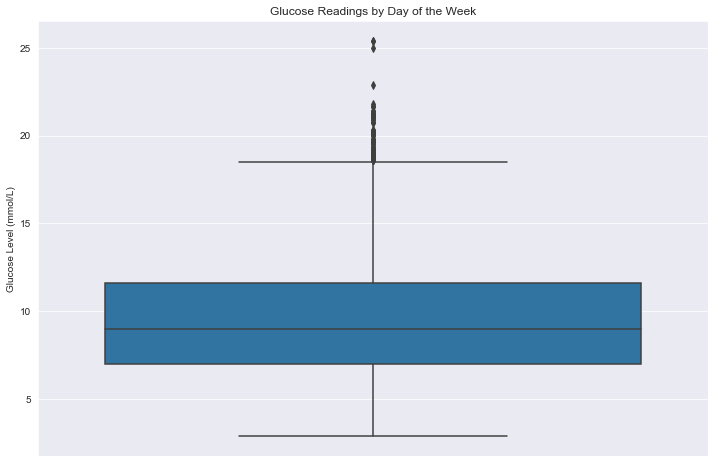

In [35]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, y="Scan Glucose mmol/L")

plt.title('Glucose Readings by Day of the Week')
plt.ylabel('Glucose Level (mmol/L)')
plt.xticks(rotation=45)  # Improve readability of the x-axis labels
plt.show()

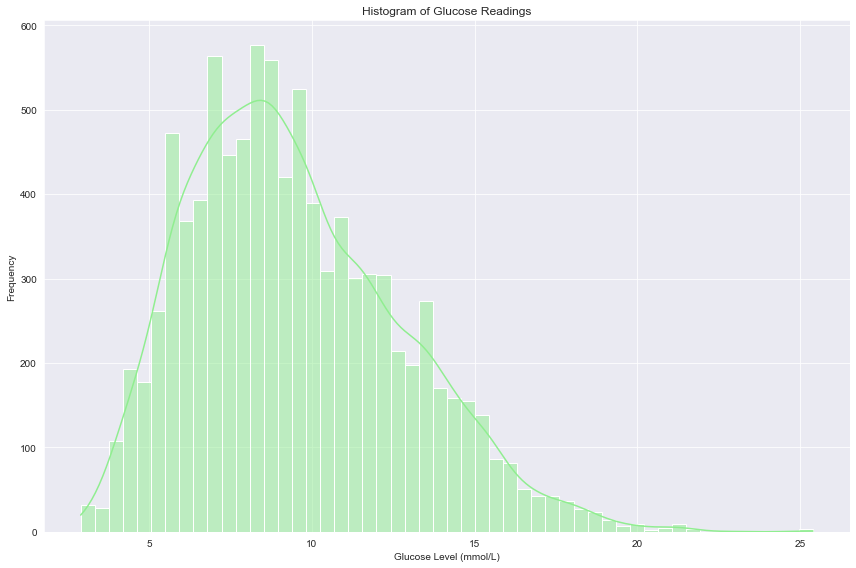

In [36]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df['Scan Glucose mmol/L'], kde=True, color='lightgreen')
plt.title('Histogram of Glucose Readings')
plt.xlabel('Glucose Level (mmol/L)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Time series Analysis

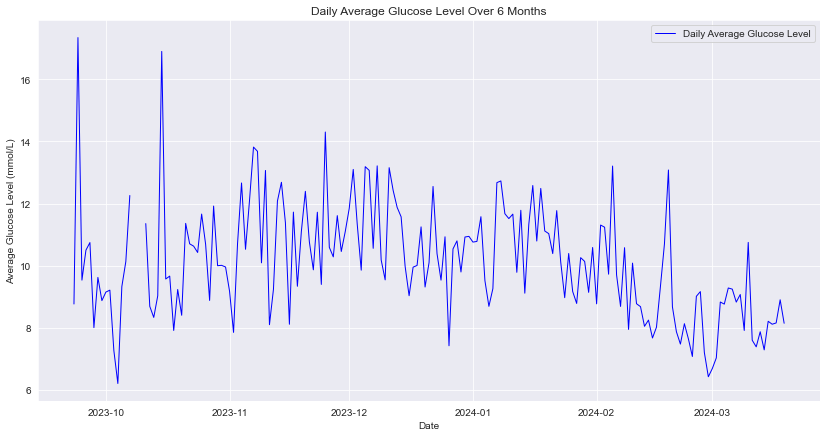

In [37]:
# Calculate daily averages if there are multiple readings per day

daily_avg = df.resample('D').mean()

plt.figure(figsize=(14, 7))
plt.plot(daily_avg.index, daily_avg['Scan Glucose mmol/L'], label='Daily Average Glucose Level', color='blue',
         linewidth=1)

plt.title('Daily Average Glucose Level Over 6 Months')
plt.xlabel('Date')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Average Glucose Level (mmol/L)')

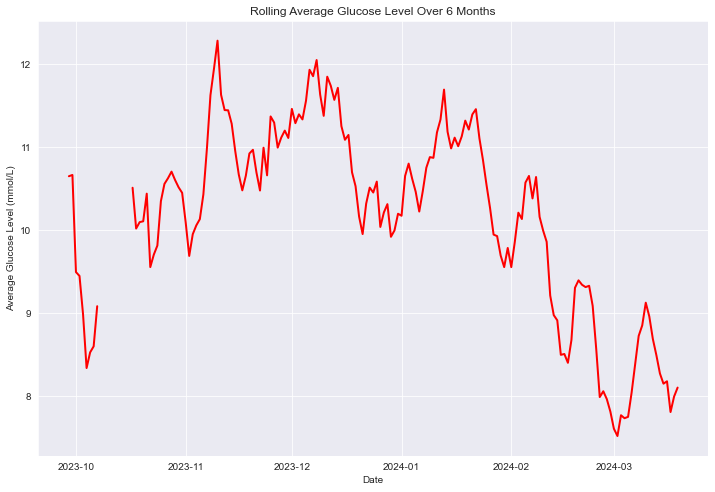

In [38]:
rolling_avg = daily_avg['Scan Glucose mmol/L'].rolling(window=7).mean()  # 7-day rolling average
plt.figure(figsize=(12, 8))
plt.plot(daily_avg.index, rolling_avg, label='7-Day Rolling Average', color='red', linewidth=2)

plt.title('Rolling Average Glucose Level Over 6 Months')
plt.xlabel('Date')
plt.ylabel('Average Glucose Level (mmol/L)')

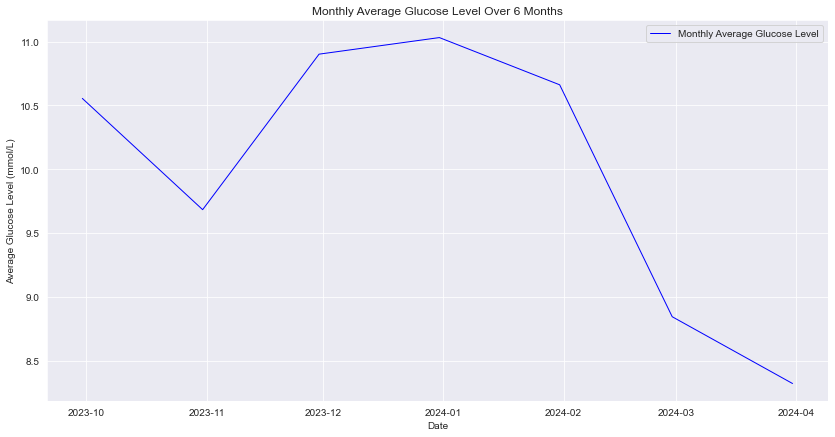

In [39]:
# Calculate daily averages if there are multiple readings per day
monthly_avg = df.resample('M').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg['Scan Glucose mmol/L'], label='Monthly Average Glucose Level', color='blue',
         linewidth=1)

plt.title('Monthly Average Glucose Level Over 6 Months')
plt.xlabel('Date')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.legend()
plt.grid(True)
plt.show()

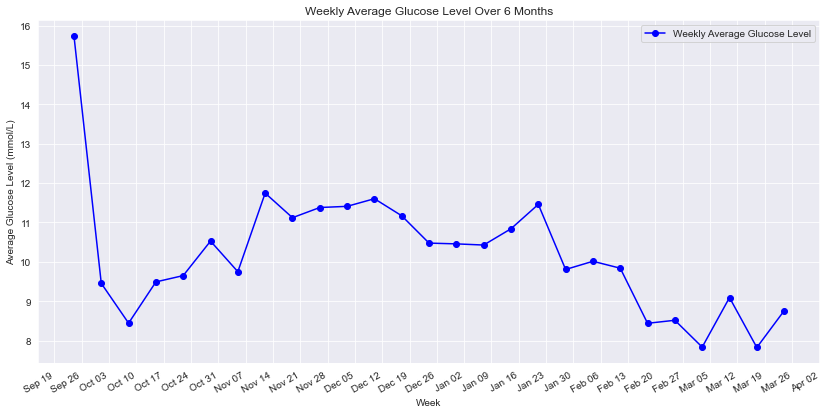

In [40]:
weekly_avg = df.resample('W').mean()
plt.figure(figsize=(14, 7))
plt.plot(weekly_avg.index, weekly_avg['Scan Glucose mmol/L'], marker='o', linestyle='-', color='blue',
         label='Weekly Average Glucose Level')

# Improve the x-axis to show months more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gcf().autofmt_xdate()  # Rotation

plt.title('Weekly Average Glucose Level Over 6 Months')
plt.xlabel('Week')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.legend()
plt.grid(True)

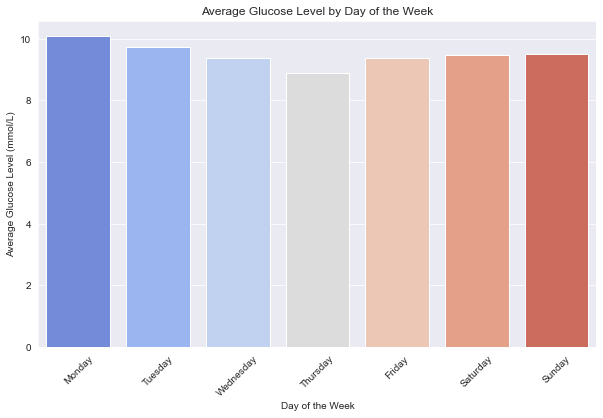

In [41]:
df['day_of_week'] = df.index.day_name()  # Add a column with the day name
daily_avg = df.groupby('day_of_week')['Scan Glucose mmol/L'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=daily_avg.index, y=daily_avg.values, palette='coolwarm')
plt.title('Average Glucose Level by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.xticks(rotation=45)
plt.show()

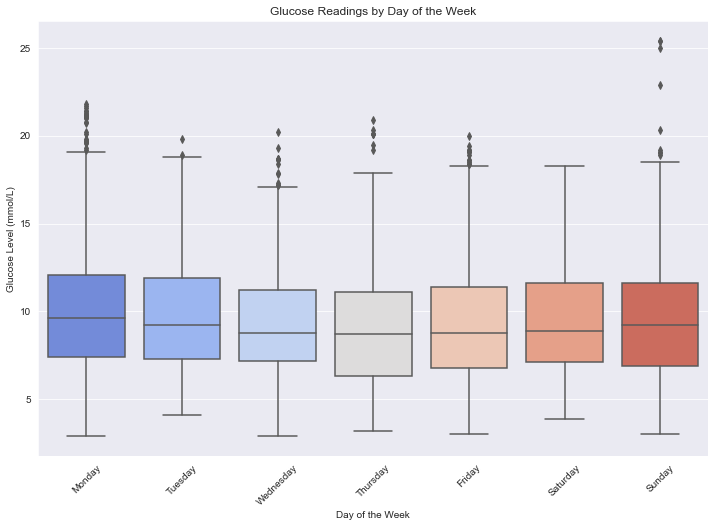

In [42]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='day_of_week', y='Scan Glucose mmol/L', data=df, palette="coolwarm",
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title('Glucose Readings by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Glucose Level (mmol/L)')
plt.xticks(rotation=45)  # Improve readability of the x-axis labels
plt.show()

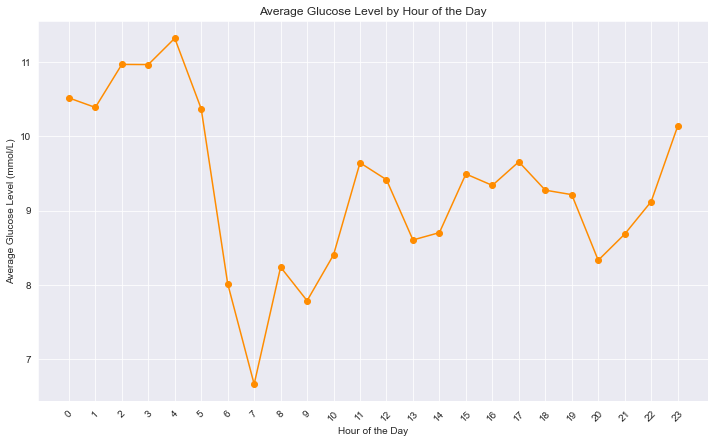

In [43]:
df['hour_of_day'] = df.index.hour  # Adding a column with the hour of the day
hourly_avg = df.groupby('hour_of_day')['Scan Glucose mmol/L'].mean()

# Plotting
plt.figure(figsize=(12, 7))
hourly_avg.plot(kind='line', marker='o', linestyle='-', color='darkorange')
plt.title('Average Glucose Level by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Glucose Level (mmol/L)')
plt.xticks(range(0, 24), rotation = 45)  # Ensure x-ticks for every hour
plt.grid(True)
plt.show()

## Time series Forecasting

### Arima Model for Forecasting Blood sugar for hourly intervals

In [44]:
# Resampling my timeseries data

Hourly_avg = df.resample('60T').mean().round(1)

# Checking 
print(len(Hourly_avg))
print(Hourly_avg['Scan Glucose mmol/L'].isna().sum())

# Half of the Data is missing, requires Imputation

4270
2077
